In [1]:
!pip uninstall -y keras tensorflow
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install transformers
!pip install transformers datasets torch
# !pip install --upgrade --force-reinstall pyarrow==16.1.0 --no-deps -q
!pip install -U transformers datasets accelerate

# import importlib, pyarrow
# importlib.reload(pyarrow)

from datasets import Dataset

Looking in indexes: https://download.pytorch.org/whl/cpu


In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch

!pip install ipywidgets
# jupyter nbextension enable --py widgetsnbextension --sys-prefix
!pip install jupyterlab_widgets


In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV

# Import dataset from final_data_version.csv
df_balanced = pd.read_csv("../data/final_data_version.csv")

# Split my data
(X_train, X_test, y_train, y_test) = train_test_split(df_balanced.description, df_balanced.category, test_size=0.2, random_state=42)

In [4]:
# Prepare data
le = LabelEncoder()
df_balanced['label'] = le.fit_transform(df_balanced['category'])

# Include title and author metadata
df_balanced['full_text'] = (
    df_balanced['title'] + ' by ' +
    df_balanced['authors'] + ': ' +
    df_balanced['description']
)

# Ensure correct column name
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced['full_text'],
    df_balanced['label'],
    test_size=0.2,
    stratify=df_balanced['label'],
    random_state=42
)

# Convert to Hugging Face Datasets
train_dataset = Dataset.from_dict({'text': X_train.tolist(), 'label': y_train.tolist()})
test_dataset  = Dataset.from_dict({'text': X_test.tolist(),  'label': y_test.tolist()})

In [5]:
# Experiment using the roBERTa - include metadata

# roberta Model
roberta_model_epochs = "roberta-base"

tokenizer_roberta_epochs = AutoTokenizer.from_pretrained(roberta_model_epochs)

def tokenize(batch):
    return tokenizer_roberta_epochs(batch['text'], padding='max_length', truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset  = test_dataset.map(tokenize, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
# Load model
num_labels = len(le.classes_)

# Load your pretrained model with the correct number of output labels
model = AutoModelForSequenceClassification.from_pretrained(
    roberta_model_epochs,  # your pretrained model path or name
    num_labels=num_labels
)

# Training config
training_args = TrainingArguments(
    output_dir="./results",
    do_eval=True,   
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,   
    metric_for_best_model="f1", 
    greater_is_better=True,
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_ratio=0.1, 
    logging_dir="./logs",
    logging_steps=100,
    save_total_limit=2,
    report_to="none" 
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "f1": f1_score(labels, preds, average="weighted"),
    }


# Trainer
trainer_roberta_epochs = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer_roberta_epochs,
    compute_metrics=compute_metrics 
)

# Train
trainer_roberta_epochs.train()

Map:   0%|          | 0/32021 [00:00<?, ? examples/s]

Map:   0%|          | 0/8006 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/gs/rm1mjp5x5ybc93h8m4xwbfyr0000gn/T/ipykernel_51984/1603992767.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_roberta_epochs = Trainer(
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=16012, training_loss=0.6084269659983168, metrics={'train_runtime': 9542.9772, 'train_samples_per_second': 13.422, 'train_steps_per_second': 1.678, 'total_flos': 1.6851217242765312e+16, 'train_loss': 0.6084269659983168, 'epoch': 4.0})

In [85]:
# Save model
trainer_roberta_epochs.save_model("./roberta_model")
tokenizer_roberta_epochs.save_pretrained("./roberta_model")

('./roberta_model/tokenizer_config.json',
 './roberta_model/special_tokens_map.json',
 './roberta_model/vocab.json',
 './roberta_model/merges.txt',
 './roberta_model/added_tokens.json',
 './roberta_model/tokenizer.json')

In [43]:
import numpy as np
from sklearn.metrics import classification_report

# ----- Run prediction -----
predictions = trainer_roberta_epochs.predict(test_dataset)
y_pred_roberta_epochs = predictions.predictions.argmax(axis=1)

# Convert predictions to string labels
y_pred_labels = le.inverse_transform(y_pred_roberta_epochs)

# ----- Normalize y_test to string labels -----
y_test_array = np.array(y_test)

if y_test_array.dtype.kind in {"i", "u"}:  # numeric labels
    y_true_labels = le.inverse_transform(y_test_array)
else:
    # mixed or string labels → force everything to string
    y_true_labels = y_test_array.astype(str)

# ----- Final evaluation (NO target_names needed) -----
print(classification_report(y_true_labels, y_pred_labels))


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


                         precision    recall  f1-score   support

                    art       0.74      0.67      0.70       900
       business/finance       0.82      0.83      0.82       900
fantasy/science fiction       0.82      0.77      0.79       900
                   food       0.83      0.87      0.85       879
                history       0.71      0.70      0.70       900
  religion/spirituality       0.76      0.75      0.76       900
                romance       0.86      0.85      0.86       900
                science       0.69      0.76      0.72       900
               thriller       0.79      0.83      0.81       827

               accuracy                           0.78      8006
              macro avg       0.78      0.78      0.78      8006
           weighted avg       0.78      0.78      0.78      8006



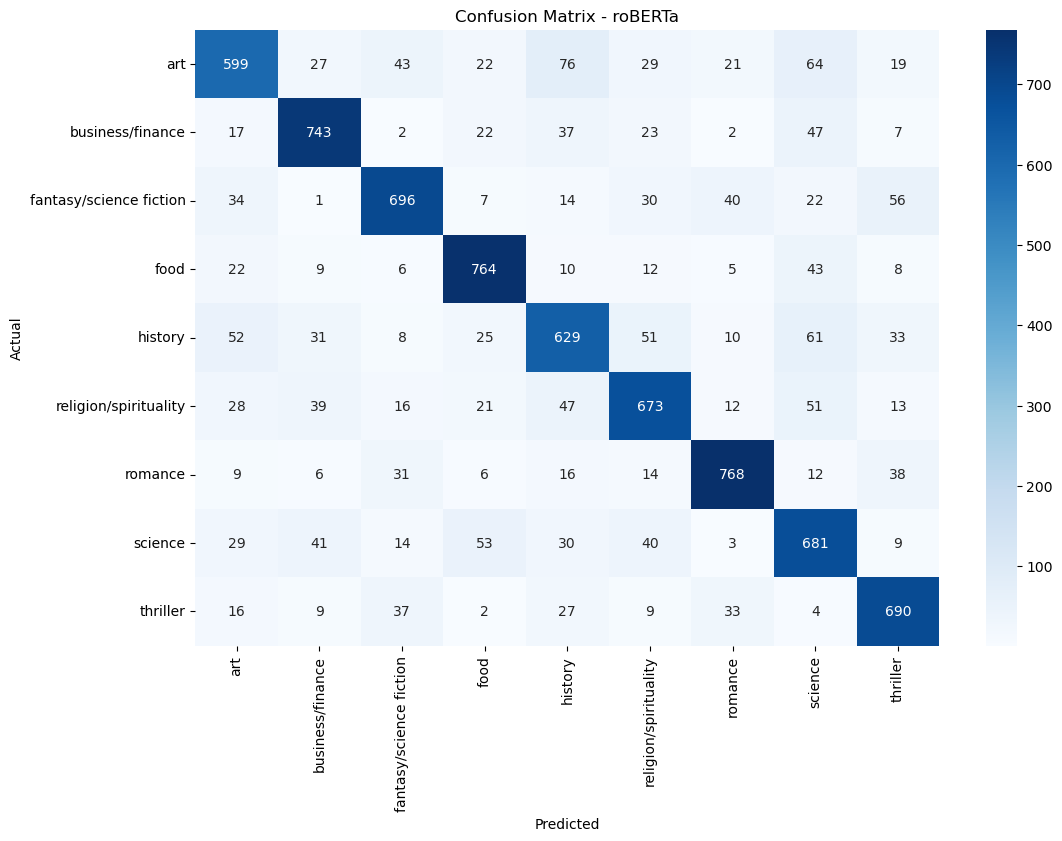

In [45]:
# Confusion matrix roBERTa

cm = confusion_matrix(y_test, y_pred_roberta_epochs, labels=range(len(le.classes_)))
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_,
            yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - roBERTa')
plt.show()

In [47]:
!pip install wordcloud
!pip install captum

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Word Cloud for art


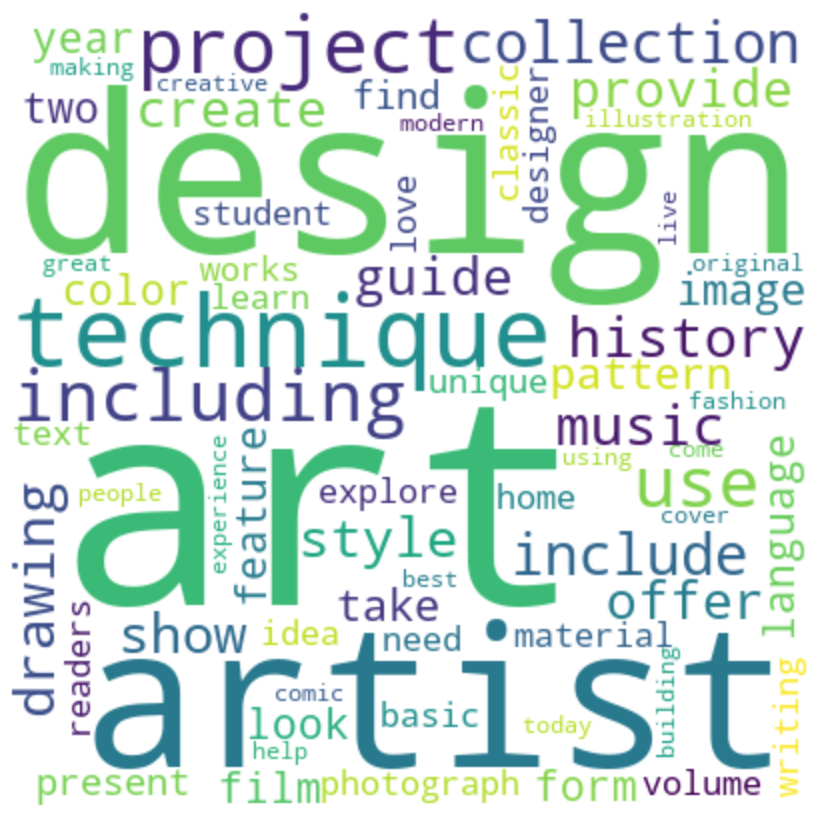

Word Cloud for business/finance


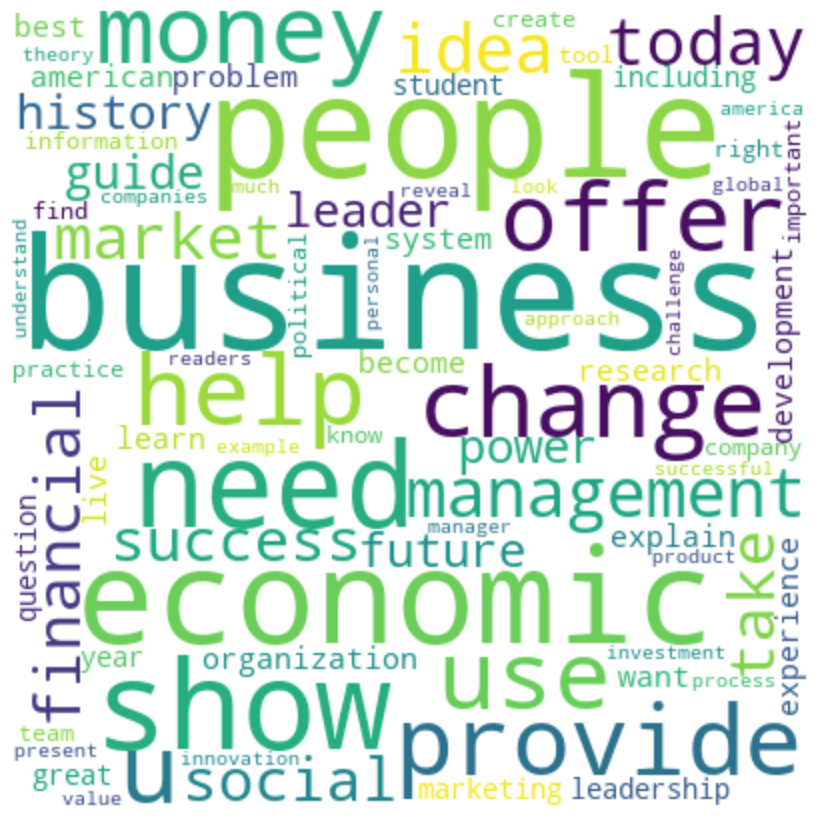

Word Cloud for fantasy/science fiction


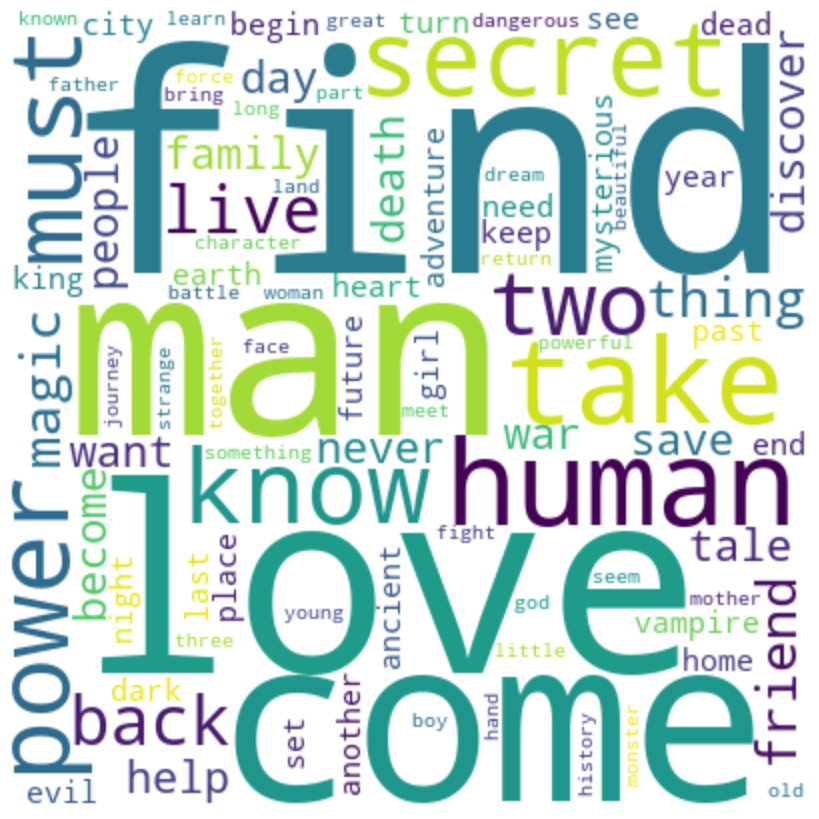

Word Cloud for food


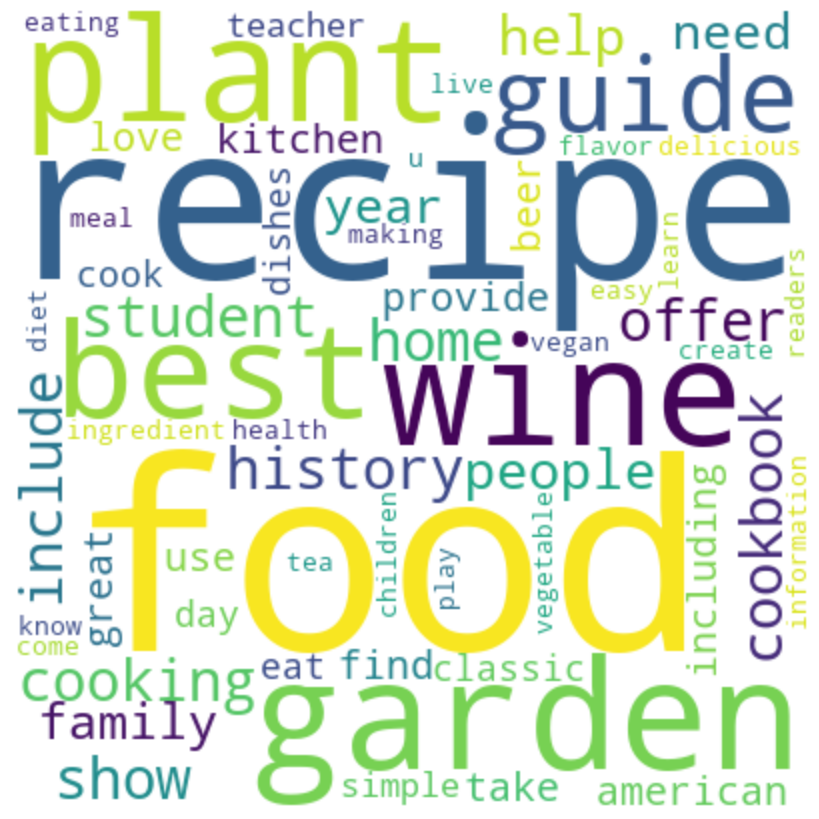

Word Cloud for history


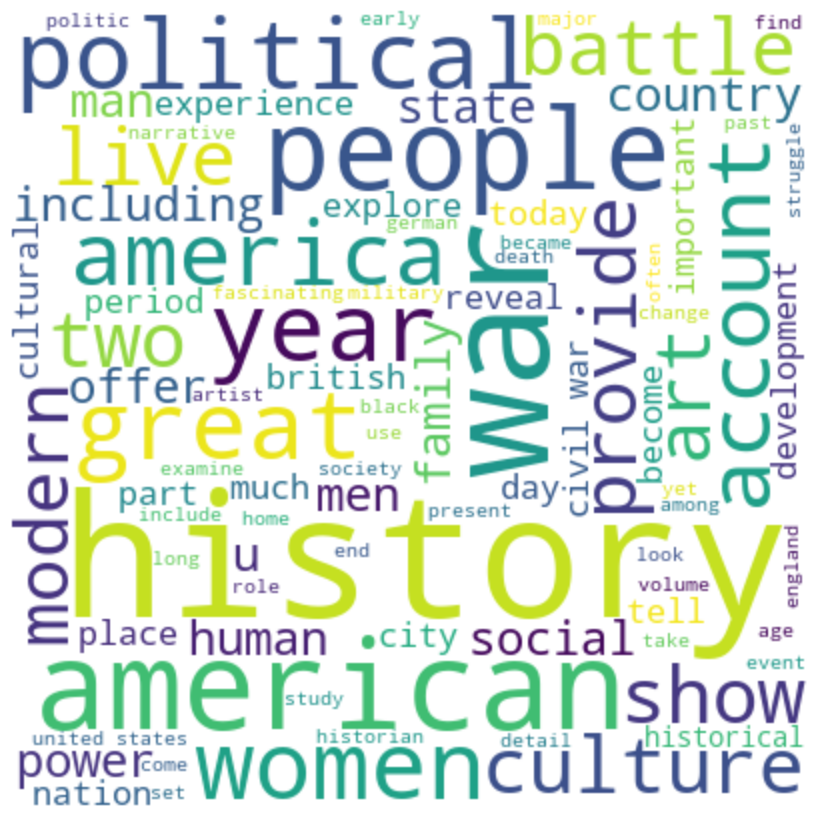

Word Cloud for religion/spirituality


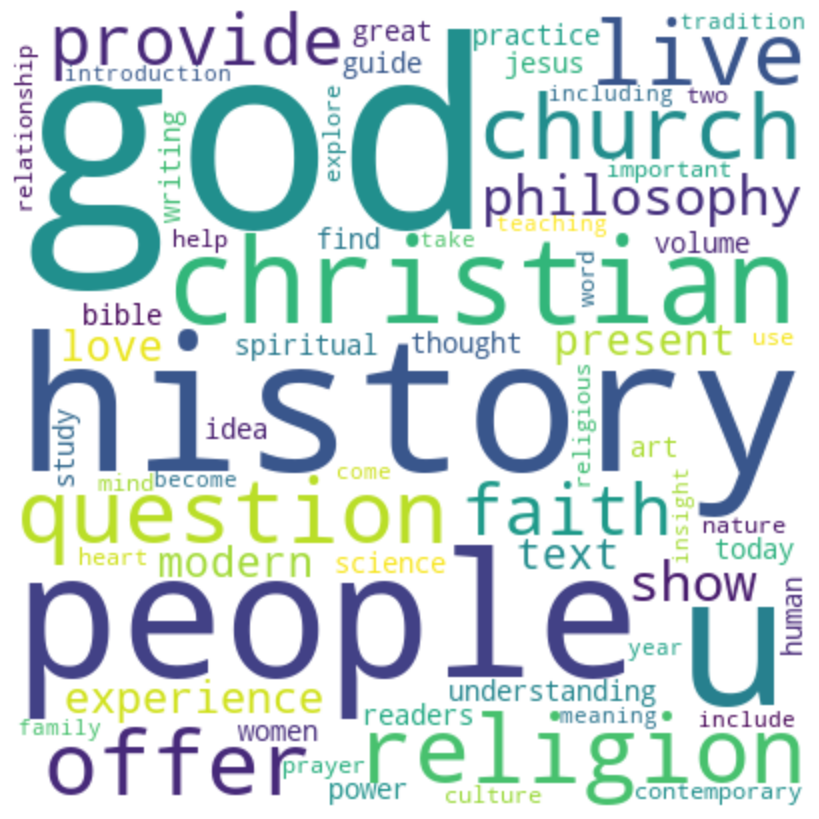

Word Cloud for romance


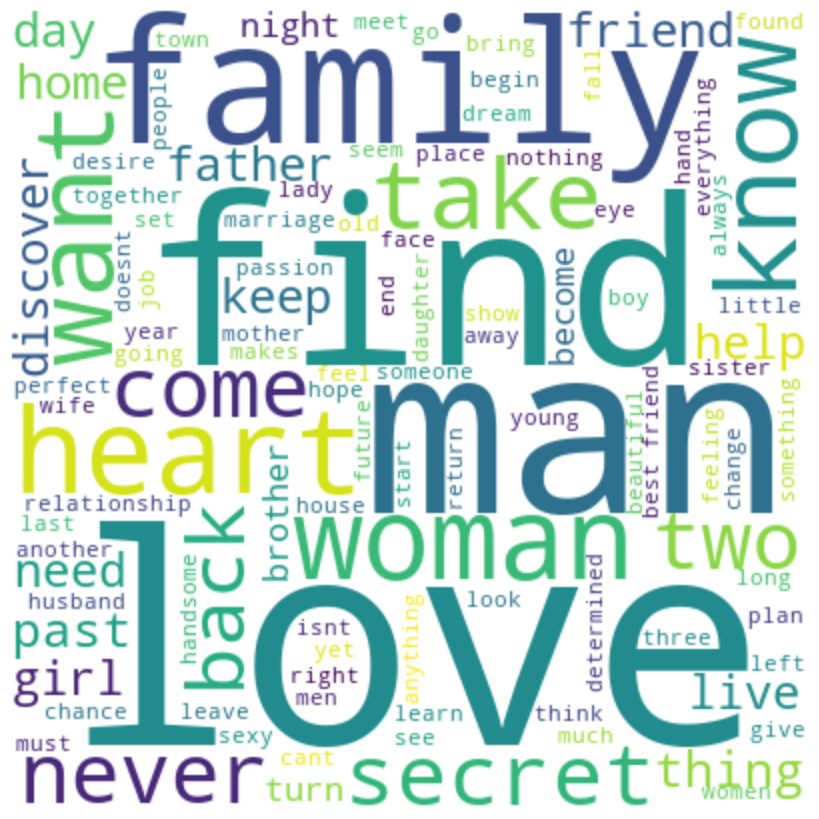

Word Cloud for science


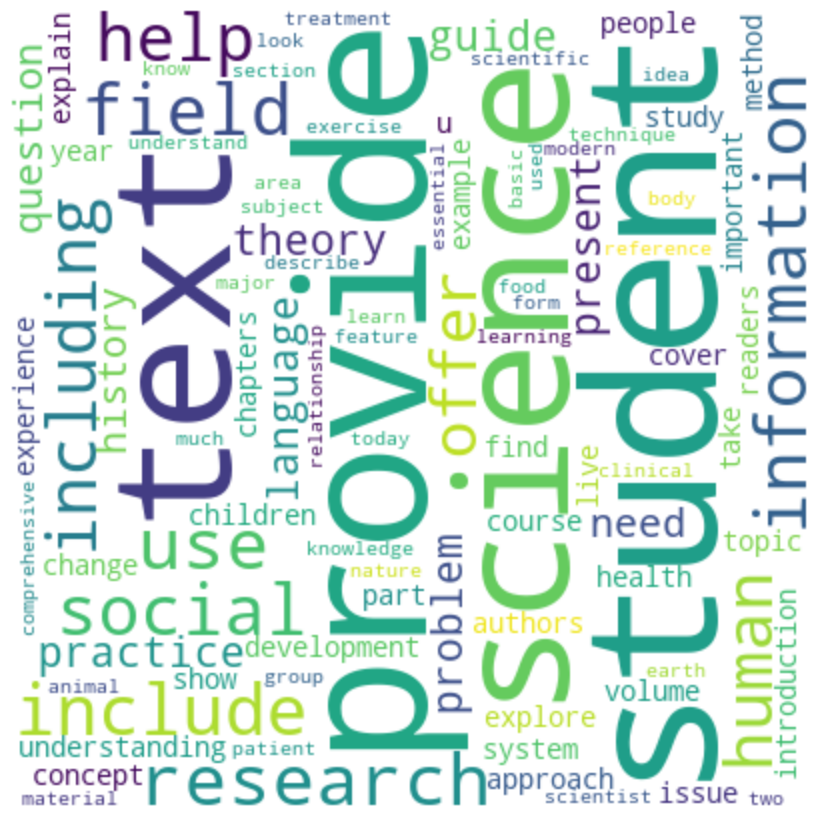

Word Cloud for thriller


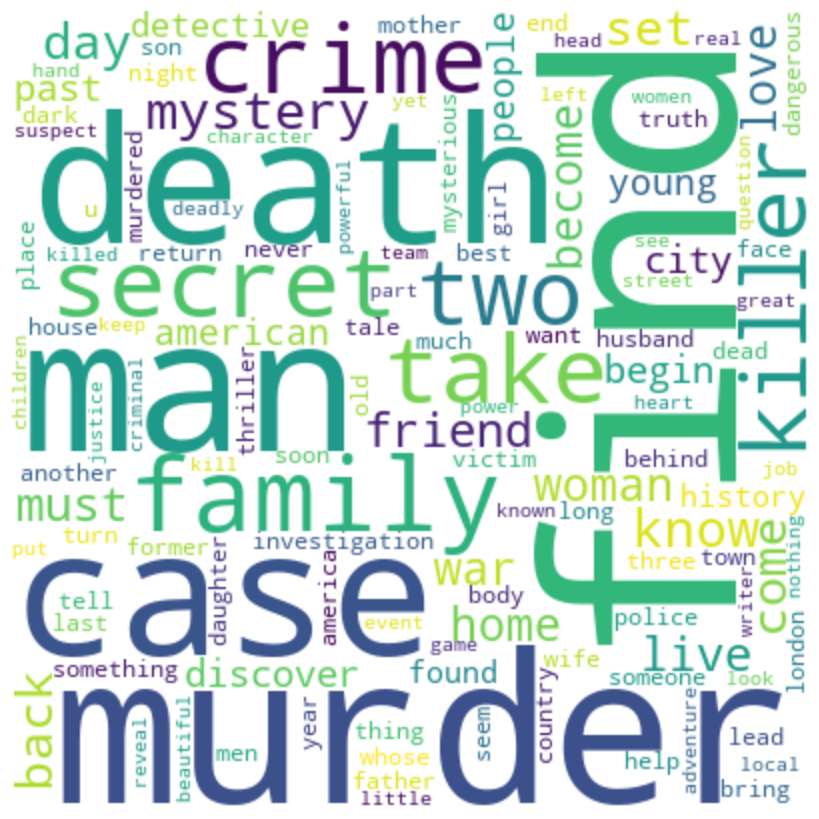

In [49]:
# Word Cloud

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Custom word stops that are common between categories to remove meaningless words
custom_words = {
    'book', 'books', 'story', 'stories', 'novel', 'author', 'writes', 'written',
    'one', 'also', 'many', 'would', 'could', 'may', 'might', 'like', 'well',
    'plot', 'said', 'told', 'made', 'make', 'every', 'around', 'across', 'within',
    'even', 'though', 'however', 'still', 'good', 'new', 'time', 'life', 'way',
    'chapter', 'read', 'reading', 'reader', 'series', 'pages', 'page', 'one', 'hes',
    'shes', 'she', 'he', 'will', 'work', 'now', 'will', 'first', 'world'
}

# Define stopwords
stopwords = set(STOPWORDS)
stopwords.update(custom_words)

# Function to generate a word cloud for a given category
def print_wordCloud(category, text):
    if not text.strip():
        print(f"No data for category: {category}")
        return
    print(f"Word Cloud for {category}")
    wordcloud = WordCloud(
        width=400,
        height=400,
        background_color='white',
        stopwords=stopwords,
        colormap='viridis',
        min_font_size=10
    ).generate(text)
    
    plt.figure(figsize=(8, 8), facecolor='white')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

# Function to combine all descriptions for a specific category
def make_string(category_name, data):
    text = ""
    for _, row in data.iterrows():
        if row['category'] == category_name:
            text += str(row['description']) + ' '
    return text

# Example usage
for category in le.classes_:
    combined_text = make_string(category, df_balanced)
    print_wordCloud(category, combined_text)


# Testing input against the model

In [87]:
import os
print(os.listdir("./roberta_model"))

['model.safetensors', 'tokenizer_config.json', 'special_tokens_map.json', 'config.json', 'tokenizer.json', 'merges.txt', 'training_args.bin', 'vocab.json']


In [89]:
from transformers import AutoConfig
config = AutoConfig.from_pretrained("./roberta_model")


In [181]:
from sklearn.preprocessing import LabelEncoder
import joblib

FINAL_LABELS = [
    'art',
    'business/finance',
    'fantasy/science fiction',
    'food',
    'history',
    'religion/spirituality',
    'romance',
    'science',
    'thriller'
]

le = LabelEncoder()
le.fit(FINAL_LABELS)

joblib.dump(le, "label_encoder.pkl")
print("Saved NEW label encoder:", le.classes_)

Saved NEW label encoder: ['art' 'business/finance' 'fantasy/science fiction' 'food' 'history'
 'religion/spirituality' 'romance' 'science' 'thriller']


In [195]:
import torch
import json
import joblib
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = "./roberta_model"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

le = joblib.load("label_encoder.pkl")

def predict_genre(description, title="", authors=""):
    text = f"{title} by {authors}: {description}".strip()

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=256
    )

    with torch.no_grad():
        logits = model(**inputs).logits
        pred_id = logits.argmax(dim=1).item()

    return le.inverse_transform([pred_id])[0]


def test_books(file_name, correct_label=None):
    json_path = Path(f"../data/json_tests/{file_name}.json")

    with open(json_path, "r", encoding="utf-8") as f:
        books = json.load(f)

    print(f"\n       Testing file: {file_name} ({len(books)} books)    \n")

    label_counts = {}
    correct_count = 0

    for book in books:
        pred = predict_genre(
            description=book.get("description", ""),
            title=book.get("title", ""),
            authors=book.get("authors", "")
        )

        print(f'{book["title"]} - {pred}')

        # Count predictions
        label_counts[pred] = label_counts.get(pred, 0) + 1

        if correct_label and pred == correct_label:
            correct_count += 1

    print("\nPrediction Counts:")
    for label, count in sorted(label_counts.items()):
        print(f"{label:30s} {count}")


    print(f"\nAccuracy for '{correct_label}': {correct_count}/{len(books)} = "
            f"{(correct_count / len(books)) * 100:.2f}%")

In [206]:
test_files = [
    "fantasy_novels",
    "science_fiction_novels",
    "romance_novels",
    "thriller_novels",
    "history_books",
    "art_books",
    "business_books",
    "religious_books",
    "science_books",
    "spiritual_books",
    "food_books"
]

labels = [
    "fantasy/science fiction",
    "fantasy/science fiction",
    "romance",
    "thriller",
    "history",
    "art",
    "business/finance",
    "religion/spirituality",
    "science",
    "religion/spirituality",
    "food"
]

# Correct iteration using enumerate
for idx, file in enumerate(test_files):
    test_books(file, correct_label=labels[idx])


       Testing file: fantasy_novels (27 books)    

The Lord of the Rings - fantasy/science fiction
A Game of Thrones - fantasy/science fiction
The Name of the Wind - fantasy/science fiction
Mistborn: The Final Empire - fantasy/science fiction
The Wheel of Time: The Eye of the World - fantasy/science fiction
The Way of Kings - fantasy/science fiction
The Hobbit - fantasy/science fiction
The Silver Citadel - fantasy/science fiction
Thornborn - fantasy/science fiction
Ashes of the First Dragon - fantasy/science fiction
Mooncarver - fantasy/science fiction
The Library of Fallen Names - fantasy/science fiction
Stormfeather - fantasy/science fiction
The Bone Harps - fantasy/science fiction
Blood of the Winter King - fantasy/science fiction
Gilded Serpent - fantasy/science fiction
The Lantern of Echo Vale - fantasy/science fiction
Crown of Morrowind - fantasy/science fiction
The Warden of Hollowfen - fantasy/science fiction
Feathers of Fire - fantasy/science fiction
The Sorcerer's Debt - fa